In [360]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [361]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [362]:
NUM_CLASSES = 4

# 学習データ読み込み

In [363]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [364]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [365]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [366]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(160, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [367]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_52 (Dropout)        (None, 42)                0         
                                                                 
 dense_68 (Dense)            (None, 40)                1720      
                                                                 
 dropout_53 (Dropout)        (None, 40)                0         
                                                                 
 dense_69 (Dense)            (None, 160)               6560      
                                                                 
 dropout_54 (Dropout)        (None, 160)               0         
                                                                 
 dense_70 (Dense)            (None, 80)                12880     
                                                                 
 dropout_55 (Dropout)        (None, 80)              

In [368]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [369]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [370]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
21/22 [===========================>..] - ETA: 0s - loss: 1.3807 - accuracy: 0.3062
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
22/22 [==============================] - 1s 10ms/step - loss: 1.3805 - accuracy: 0.3059 - val_loss: 1.3216 - val_accuracy: 0.5838
Epoch 2/1000
20/22 [==========================>...] - ETA: 0s - loss: 1.3099 - accuracy: 0.3914
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
22/22 [==============================] - 0s 6ms/step - loss: 1.3087 - accuracy: 0.3893 - val_loss: 1.0984 - val_accuracy: 0.5316
Epoch 3/1000
20/22 [==========================>...] - ETA: 0s - loss: 1.1832 - accuracy: 0.4531
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
22/22 [==============================] - 0s 6ms/step - loss: 1.1817 - accuracy: 0.4526 - val_loss: 0.8977 - val_accuracy: 0.5805
Epoch 4/1000
19/22 [========================>.....] - ETA: 0s - loss: 1.0862 - accuracy: 0.4762


In [371]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

8/8 [==============================] - 0s 1ms/step - loss: 0.3297 - accuracy: 0.9589


In [372]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [373]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[9.8869252e-01 5.7282443e-05 7.4989352e-05 1.1175262e-02]
0


# 混同行列

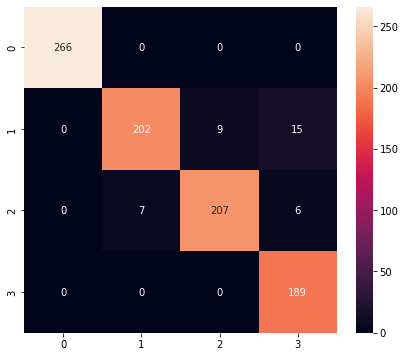

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       266
           1       0.97      0.89      0.93       226
           2       0.96      0.94      0.95       220
           3       0.90      1.00      0.95       189

    accuracy                           0.96       901
   macro avg       0.96      0.96      0.96       901
weighted avg       0.96      0.96      0.96       901



In [374]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [375]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [376]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\you_a\AppData\Local\Temp\tmpl_07ez72\assets


INFO:tensorflow:Assets written to: C:\Users\you_a\AppData\Local\Temp\tmpl_07ez72\assets


26976

# 推論テスト

In [377]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [378]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [379]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [380]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [381]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.891150e-01 5.578701e-05 7.315134e-05 1.075607e-02]
0
